In [1]:
import keras
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

from numba import jit, float64, int64

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize

In [2]:
def make_train_test(data, test_size=0.3):
    sbd = data[data['sbj'] == 0]
    X_train, X_test, y1, y2 = train_test_split(sbd, sbd, test_size=test_size, random_state=1111)
    for i in range(1, data.sbj.max()+1):
        sbd = data[data['sbj'] == i]
        tr, ts, y1, y2 = train_test_split(sbd, sbd, test_size=test_size, random_state=1111)
        X_train = pd.concat([X_train, tr])
        X_test = pd.concat([X_test, ts])
        
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

In [3]:
@jit(nopython=True)
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [4]:
data_df = pd.read_csv('../../../_data/Tavares2017.csv')
data_df['rt'] /= 1000

data_df.rename(columns={'subject': 'sbj'}, inplace=True)

mean_rt = data_df.groupby('sbj')['rt'].mean()
std_rt = data_df.groupby('sbj')['rt'].std()
RT_Max = mean_rt + 2 * std_rt

rt_max = []
for i in range(data_df.shape[0]):
    rt_max.append(RT_Max[data_df['sbj'][i]])
data_df['rt_max'] = rt_max
data_df = data_df[(data_df['rt']>0.25) & (data_df['rt']<data_df['rt_max'])].reset_index(drop=True)

data_df.reset_index(drop=True, inplace=True)

data_df['Right Value - Left Value'] = data_df['item_value_1'] - data_df['item_value_0']

data_df['gaze diff'] = data_df['gaze_1'] - data_df['gaze_0']
kbins = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['gaze diff'] = kbins.fit_transform(data_df[['gaze diff']])
mms = MinMaxScaler(feature_range=(-1, 1))
data_df['Dwell Time Advantage (R - L)'] = mms.fit_transform(data_df[['gaze diff']])


min_rt = data_df.groupby(by='sbj')['rt'].min()

In [5]:
tr_df, ts_df = make_train_test(data_df, test_size=0.4)

obs_train = np.asarray(tr_df[['rt', 'choice', 'sbj']])
X_train = np.asarray(tr_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1']])

obs_test = np.asarray(ts_df[['rt', 'choice', 'sbj']])
X_test = np.asarray(ts_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1']])

print(X_train.shape, X_test.shape)

(18269, 4) (12195, 4)


In [6]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):

    sbj_indices = tf.cast(data[:, 2], tf.int32)

    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))

    ll1 = (1 - data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 0]))

    return -2*tf.reduce_sum(tf.math.log(tf.maximum(ll1 + ll2, 1e-14)), axis=-1)

In [7]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [8]:
layers_neuron = [10, 10, 8, 5]
input_shape = 4
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 87        
                                                                 
Total params: 380 (1.48 KB)
Trainable params: 380 (1.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [9]:
sbj_indices = tf.cast(obs_train[:, 2], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [10]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=3500)

Epoch 1/3500
1/1 [==============================] - 1s 651ms/step - loss: 96675.0859
Epoch 2/3500
1/1 [==============================] - 0s 5ms/step - loss: 96268.4844
Epoch 3/3500
1/1 [==============================] - 0s 6ms/step - loss: 95972.9688
Epoch 4/3500
1/1 [==============================] - 0s 5ms/step - loss: 95723.6250
Epoch 5/3500
1/1 [==============================] - 0s 4ms/step - loss: 95500.3906
Epoch 6/3500
1/1 [==============================] - 0s 5ms/step - loss: 95294.4219
Epoch 7/3500
1/1 [==============================] - 0s 5ms/step - loss: 95100.9688
Epoch 8/3500
1/1 [==============================] - 0s 5ms/step - loss: 94917.1641
Epoch 9/3500
1/1 [==============================] - 0s 5ms/step - loss: 94741.0469
Epoch 10/3500
1/1 [==============================] - 0s 5ms/step - loss: 94571.2812
Epoch 11/3500
1/1 [==============================] - 0s 6ms/step - loss: 94406.8594
Epoch 12/3500
1/1 [==============================] - 0s 5ms/step - loss: 94247.0156

1/1 [==============================] - 0s 6ms/step - loss: 85242.8906
Epoch 99/3500
1/1 [==============================] - 0s 6ms/step - loss: 85167.2109
Epoch 100/3500
1/1 [==============================] - 0s 7ms/step - loss: 85091.9844
Epoch 101/3500
1/1 [==============================] - 0s 6ms/step - loss: 85017.2188
Epoch 102/3500
1/1 [==============================] - 0s 6ms/step - loss: 84942.9062
Epoch 103/3500
1/1 [==============================] - 0s 6ms/step - loss: 84869.0469
Epoch 104/3500
1/1 [==============================] - 0s 7ms/step - loss: 84795.6406
Epoch 105/3500
1/1 [==============================] - 0s 6ms/step - loss: 84722.6719
Epoch 106/3500
1/1 [==============================] - 0s 6ms/step - loss: 84650.1406
Epoch 107/3500
1/1 [==============================] - 0s 7ms/step - loss: 84578.0469
Epoch 108/3500
1/1 [==============================] - 0s 6ms/step - loss: 84506.3906
Epoch 109/3500
1/1 [==============================] - 0s 6ms/step - loss: 84435.1

1/1 [==============================] - 0s 6ms/step - loss: 79579.1875
Epoch 195/3500
1/1 [==============================] - 0s 7ms/step - loss: 79532.5469
Epoch 196/3500
1/1 [==============================] - 0s 6ms/step - loss: 79486.0625
Epoch 197/3500
1/1 [==============================] - 0s 7ms/step - loss: 79439.7266
Epoch 198/3500
1/1 [==============================] - 0s 6ms/step - loss: 79393.5469
Epoch 199/3500
1/1 [==============================] - 0s 6ms/step - loss: 79347.5000
Epoch 200/3500
1/1 [==============================] - 0s 7ms/step - loss: 79301.5859
Epoch 201/3500
1/1 [==============================] - 0s 6ms/step - loss: 79255.8047
Epoch 202/3500
1/1 [==============================] - 0s 6ms/step - loss: 79210.1406
Epoch 203/3500
1/1 [==============================] - 0s 6ms/step - loss: 79164.5938
Epoch 204/3500
1/1 [==============================] - 0s 6ms/step - loss: 79119.1641
Epoch 205/3500
1/1 [==============================] - 0s 6ms/step - loss: 79073.

1/1 [==============================] - 0s 6ms/step - loss: 75238.0156
Epoch 291/3500
1/1 [==============================] - 0s 6ms/step - loss: 75190.9688
Epoch 292/3500
1/1 [==============================] - 0s 6ms/step - loss: 75143.8750
Epoch 293/3500
1/1 [==============================] - 0s 6ms/step - loss: 75096.7500
Epoch 294/3500
1/1 [==============================] - 0s 6ms/step - loss: 75049.5938
Epoch 295/3500
1/1 [==============================] - 0s 6ms/step - loss: 75002.4219
Epoch 296/3500
1/1 [==============================] - 0s 6ms/step - loss: 74955.2422
Epoch 297/3500
1/1 [==============================] - 0s 6ms/step - loss: 74908.0547
Epoch 298/3500
1/1 [==============================] - 0s 6ms/step - loss: 74860.8750
Epoch 299/3500
1/1 [==============================] - 0s 6ms/step - loss: 74813.7188
Epoch 300/3500
1/1 [==============================] - 0s 6ms/step - loss: 74766.5625
Epoch 301/3500
1/1 [==============================] - 0s 6ms/step - loss: 74719.

1/1 [==============================] - 0s 7ms/step - loss: 70824.2188
Epoch 387/3500
1/1 [==============================] - 0s 7ms/step - loss: 70777.6797
Epoch 388/3500
1/1 [==============================] - 0s 7ms/step - loss: 70731.0312
Epoch 389/3500
1/1 [==============================] - 0s 7ms/step - loss: 70684.2734
Epoch 390/3500
1/1 [==============================] - 0s 7ms/step - loss: 70637.3984
Epoch 391/3500
1/1 [==============================] - 0s 6ms/step - loss: 70590.4062
Epoch 392/3500
1/1 [==============================] - 0s 7ms/step - loss: 70543.2734
Epoch 393/3500
1/1 [==============================] - 0s 7ms/step - loss: 70496.0000
Epoch 394/3500
1/1 [==============================] - 0s 7ms/step - loss: 70448.5781
Epoch 395/3500
1/1 [==============================] - 0s 6ms/step - loss: 70400.9922
Epoch 396/3500
1/1 [==============================] - 0s 6ms/step - loss: 70353.2266
Epoch 397/3500
1/1 [==============================] - 0s 7ms/step - loss: 70305.

1/1 [==============================] - 0s 7ms/step - loss: 64923.6836
Epoch 483/3500
1/1 [==============================] - 0s 8ms/step - loss: 64862.5156
Epoch 484/3500
1/1 [==============================] - 0s 7ms/step - loss: 64801.5195
Epoch 485/3500
1/1 [==============================] - 0s 7ms/step - loss: 64740.6523
Epoch 486/3500
1/1 [==============================] - 0s 7ms/step - loss: 64679.9570
Epoch 487/3500
1/1 [==============================] - 0s 6ms/step - loss: 64619.4375
Epoch 488/3500
1/1 [==============================] - 0s 6ms/step - loss: 64559.0625
Epoch 489/3500
1/1 [==============================] - 0s 7ms/step - loss: 64498.8828
Epoch 490/3500
1/1 [==============================] - 0s 8ms/step - loss: 64438.8828
Epoch 491/3500
1/1 [==============================] - 0s 7ms/step - loss: 64379.0820
Epoch 492/3500
1/1 [==============================] - 0s 7ms/step - loss: 64319.4727
Epoch 493/3500
1/1 [==============================] - 0s 6ms/step - loss: 64260.

1/1 [==============================] - 0s 7ms/step - loss: 60045.8086
Epoch 579/3500
1/1 [==============================] - 0s 8ms/step - loss: 60003.6992
Epoch 580/3500
1/1 [==============================] - 0s 7ms/step - loss: 59961.6016
Epoch 581/3500
1/1 [==============================] - 0s 8ms/step - loss: 59919.8633
Epoch 582/3500
1/1 [==============================] - 0s 7ms/step - loss: 59878.0898
Epoch 583/3500
1/1 [==============================] - 0s 7ms/step - loss: 59836.7031
Epoch 584/3500
1/1 [==============================] - 0s 7ms/step - loss: 59795.2461
Epoch 585/3500
1/1 [==============================] - 0s 7ms/step - loss: 59754.1836
Epoch 586/3500
1/1 [==============================] - 0s 7ms/step - loss: 59713.0273
Epoch 587/3500
1/1 [==============================] - 0s 7ms/step - loss: 59672.2695
Epoch 588/3500
1/1 [==============================] - 0s 7ms/step - loss: 59631.4219
Epoch 589/3500
1/1 [==============================] - 0s 7ms/step - loss: 59590.

1/1 [==============================] - 0s 9ms/step - loss: 56516.8672
Epoch 675/3500
1/1 [==============================] - 0s 8ms/step - loss: 56484.4531
Epoch 676/3500
1/1 [==============================] - 0s 9ms/step - loss: 56451.7422
Epoch 677/3500
1/1 [==============================] - 0s 7ms/step - loss: 56419.4805
Epoch 678/3500
1/1 [==============================] - 0s 9ms/step - loss: 56386.9102
Epoch 679/3500
1/1 [==============================] - 0s 8ms/step - loss: 56354.7969
Epoch 680/3500
1/1 [==============================] - 0s 8ms/step - loss: 56322.3711
Epoch 681/3500
1/1 [==============================] - 0s 7ms/step - loss: 56290.3945
Epoch 682/3500
1/1 [==============================] - 0s 9ms/step - loss: 56258.1172
Epoch 683/3500
1/1 [==============================] - 0s 7ms/step - loss: 56226.2930
Epoch 684/3500
1/1 [==============================] - 0s 8ms/step - loss: 56194.1562
Epoch 685/3500
1/1 [==============================] - 0s 8ms/step - loss: 56162.

1/1 [==============================] - 0s 7ms/step - loss: 53697.9219
Epoch 771/3500
1/1 [==============================] - 0s 7ms/step - loss: 53671.8008
Epoch 772/3500
1/1 [==============================] - 0s 6ms/step - loss: 53645.3398
Epoch 773/3500
1/1 [==============================] - 0s 6ms/step - loss: 53619.3281
Epoch 774/3500
1/1 [==============================] - 0s 7ms/step - loss: 53592.9922
Epoch 775/3500
1/1 [==============================] - 0s 7ms/step - loss: 53567.0938
Epoch 776/3500
1/1 [==============================] - 0s 7ms/step - loss: 53540.8789
Epoch 777/3500
1/1 [==============================] - 0s 6ms/step - loss: 53515.0859
Epoch 778/3500
1/1 [==============================] - 0s 7ms/step - loss: 53489.0156
Epoch 779/3500
1/1 [==============================] - 0s 6ms/step - loss: 53463.3242
Epoch 780/3500
1/1 [==============================] - 0s 8ms/step - loss: 53437.4219
Epoch 781/3500
1/1 [==============================] - 0s 7ms/step - loss: 53411.

1/1 [==============================] - 0s 12ms/step - loss: 51420.5664
Epoch 867/3500
1/1 [==============================] - 0s 8ms/step - loss: 51399.4258
Epoch 868/3500
1/1 [==============================] - 0s 7ms/step - loss: 51378.1094
Epoch 869/3500
1/1 [==============================] - 0s 7ms/step - loss: 51357.0742
Epoch 870/3500
1/1 [==============================] - 0s 8ms/step - loss: 51335.8203
Epoch 871/3500
1/1 [==============================] - 0s 6ms/step - loss: 51314.8711
Epoch 872/3500
1/1 [==============================] - 0s 8ms/step - loss: 51293.6953
Epoch 873/3500
1/1 [==============================] - 0s 6ms/step - loss: 51272.8359
Epoch 874/3500
1/1 [==============================] - 0s 7ms/step - loss: 51251.7656
Epoch 875/3500
1/1 [==============================] - 0s 7ms/step - loss: 51231.0039
Epoch 876/3500
1/1 [==============================] - 0s 7ms/step - loss: 51210.0586
Epoch 877/3500
1/1 [==============================] - 0s 7ms/step - loss: 51189

1/1 [==============================] - 0s 7ms/step - loss: 49579.4258
Epoch 963/3500
1/1 [==============================] - 0s 7ms/step - loss: 49562.2734
Epoch 964/3500
1/1 [==============================] - 0s 7ms/step - loss: 49545.2578
Epoch 965/3500
1/1 [==============================] - 0s 7ms/step - loss: 49528.1133
Epoch 966/3500
1/1 [==============================] - 0s 6ms/step - loss: 49511.1211
Epoch 967/3500
1/1 [==============================] - 0s 6ms/step - loss: 49494.0625
Epoch 968/3500
1/1 [==============================] - 0s 6ms/step - loss: 49477.1797
Epoch 969/3500
1/1 [==============================] - 0s 6ms/step - loss: 49460.3242
Epoch 970/3500
1/1 [==============================] - 0s 6ms/step - loss: 49443.5156
Epoch 971/3500
1/1 [==============================] - 0s 6ms/step - loss: 49426.8203
Epoch 972/3500
1/1 [==============================] - 0s 7ms/step - loss: 49410.0000
Epoch 973/3500
1/1 [==============================] - 0s 6ms/step - loss: 49393.

1/1 [==============================] - 0s 6ms/step - loss: 48140.8203
Epoch 1058/3500
1/1 [==============================] - 0s 6ms/step - loss: 48128.3906
Epoch 1059/3500
1/1 [==============================] - 0s 7ms/step - loss: 48116.0703
Epoch 1060/3500
1/1 [==============================] - 0s 8ms/step - loss: 48103.7422
Epoch 1061/3500
1/1 [==============================] - 0s 6ms/step - loss: 48090.6094
Epoch 1062/3500
1/1 [==============================] - 0s 6ms/step - loss: 48076.8125
Epoch 1063/3500
1/1 [==============================] - 0s 7ms/step - loss: 48063.0273
Epoch 1064/3500
1/1 [==============================] - 0s 6ms/step - loss: 48049.5000
Epoch 1065/3500
1/1 [==============================] - 0s 6ms/step - loss: 48036.3359
Epoch 1066/3500
1/1 [==============================] - 0s 6ms/step - loss: 48023.7812
Epoch 1067/3500
1/1 [==============================] - 0s 6ms/step - loss: 48011.1211
Epoch 1068/3500
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 7ms/step - loss: 47045.8555
Epoch 1153/3500
1/1 [==============================] - 0s 7ms/step - loss: 47036.2891
Epoch 1154/3500
1/1 [==============================] - 0s 7ms/step - loss: 47028.1562
Epoch 1155/3500
1/1 [==============================] - 0s 6ms/step - loss: 47019.3477
Epoch 1156/3500
1/1 [==============================] - 0s 6ms/step - loss: 47010.9023
Epoch 1157/3500
1/1 [==============================] - 0s 6ms/step - loss: 46999.1406
Epoch 1158/3500
1/1 [==============================] - 0s 6ms/step - loss: 46988.5938
Epoch 1159/3500
1/1 [==============================] - 0s 6ms/step - loss: 46977.0781
Epoch 1160/3500
1/1 [==============================] - 0s 6ms/step - loss: 46967.2031
Epoch 1161/3500
1/1 [==============================] - 0s 6ms/step - loss: 46957.2539
Epoch 1162/3500
1/1 [==============================] - 0s 6ms/step - loss: 46948.5742
Epoch 1163/3500
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 7ms/step - loss: 46234.6680
Epoch 1248/3500
1/1 [==============================] - 0s 7ms/step - loss: 46227.9531
Epoch 1249/3500
1/1 [==============================] - 0s 6ms/step - loss: 46221.1094
Epoch 1250/3500
1/1 [==============================] - 0s 11ms/step - loss: 46216.1172
Epoch 1251/3500
1/1 [==============================] - 0s 7ms/step - loss: 46209.6992
Epoch 1252/3500
1/1 [==============================] - 0s 6ms/step - loss: 46204.9766
Epoch 1253/3500
1/1 [==============================] - 0s 6ms/step - loss: 46195.5508
Epoch 1254/3500
1/1 [==============================] - 0s 7ms/step - loss: 46188.7422
Epoch 1255/3500
1/1 [==============================] - 0s 6ms/step - loss: 46178.8984
Epoch 1256/3500
1/1 [==============================] - 0s 6ms/step - loss: 46171.9297
Epoch 1257/3500
1/1 [==============================] - 0s 7ms/step - loss: 46164.0430
Epoch 1258/3500
1/1 [==============================] - 0s 6ms/step - 

1/1 [==============================] - 0s 6ms/step - loss: 45669.4102
Epoch 1343/3500
1/1 [==============================] - 0s 7ms/step - loss: 45662.9844
Epoch 1344/3500
1/1 [==============================] - 0s 6ms/step - loss: 45659.2617
Epoch 1345/3500
1/1 [==============================] - 0s 6ms/step - loss: 45651.3750
Epoch 1346/3500
1/1 [==============================] - 0s 6ms/step - loss: 45646.9141
Epoch 1347/3500
1/1 [==============================] - 0s 6ms/step - loss: 45640.8281
Epoch 1348/3500
1/1 [==============================] - 0s 7ms/step - loss: 45637.1484
Epoch 1349/3500
1/1 [==============================] - 0s 6ms/step - loss: 45632.5195
Epoch 1350/3500
1/1 [==============================] - 0s 6ms/step - loss: 45629.3984
Epoch 1351/3500
1/1 [==============================] - 0s 6ms/step - loss: 45624.3281
Epoch 1352/3500
1/1 [==============================] - 0s 6ms/step - loss: 45620.0625
Epoch 1353/3500
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 45271.5859
Epoch 1438/3500
1/1 [==============================] - 0s 6ms/step - loss: 45268.0938
Epoch 1439/3500
1/1 [==============================] - 0s 6ms/step - loss: 45264.0742
Epoch 1440/3500
1/1 [==============================] - 0s 6ms/step - loss: 45261.8477
Epoch 1441/3500
1/1 [==============================] - 0s 6ms/step - loss: 45258.2148
Epoch 1442/3500
1/1 [==============================] - 0s 6ms/step - loss: 45257.6562
Epoch 1443/3500
1/1 [==============================] - 0s 6ms/step - loss: 45252.2188
Epoch 1444/3500
1/1 [==============================] - 0s 6ms/step - loss: 45250.4727
Epoch 1445/3500
1/1 [==============================] - 0s 6ms/step - loss: 45243.6055
Epoch 1446/3500
1/1 [==============================] - 0s 6ms/step - loss: 45240.7188
Epoch 1447/3500
1/1 [==============================] - 0s 6ms/step - loss: 45237.5938
Epoch 1448/3500
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 7ms/step - loss: 44986.4531
Epoch 1533/3500
1/1 [==============================] - 0s 7ms/step - loss: 44979.6016
Epoch 1534/3500
1/1 [==============================] - 0s 7ms/step - loss: 44978.4219
Epoch 1535/3500
1/1 [==============================] - 0s 7ms/step - loss: 44976.7969
Epoch 1536/3500
1/1 [==============================] - 0s 7ms/step - loss: 44976.7656
Epoch 1537/3500
1/1 [==============================] - 0s 7ms/step - loss: 44976.9766
Epoch 1538/3500
1/1 [==============================] - 0s 6ms/step - loss: 44976.4844
Epoch 1539/3500
1/1 [==============================] - 0s 6ms/step - loss: 44972.9883
Epoch 1540/3500
1/1 [==============================] - 0s 6ms/step - loss: 44972.6211
Epoch 1541/3500
1/1 [==============================] - 0s 6ms/step - loss: 44959.5469
Epoch 1542/3500
1/1 [==============================] - 0s 7ms/step - loss: 44957.6445
Epoch 1543/3500
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 44779.3008
Epoch 1628/3500
1/1 [==============================] - 0s 6ms/step - loss: 44775.3477
Epoch 1629/3500
1/1 [==============================] - 0s 6ms/step - loss: 44769.9766
Epoch 1630/3500
1/1 [==============================] - 0s 7ms/step - loss: 44765.9141
Epoch 1631/3500
1/1 [==============================] - 0s 6ms/step - loss: 44761.6250
Epoch 1632/3500
1/1 [==============================] - 0s 6ms/step - loss: 44759.4023
Epoch 1633/3500
1/1 [==============================] - 0s 6ms/step - loss: 44757.2812
Epoch 1634/3500
1/1 [==============================] - 0s 6ms/step - loss: 44756.8750
Epoch 1635/3500
1/1 [==============================] - 0s 6ms/step - loss: 44757.1562
Epoch 1636/3500
1/1 [==============================] - 0s 6ms/step - loss: 44758.7891
Epoch 1637/3500
1/1 [==============================] - 0s 6ms/step - loss: 44761.7109
Epoch 1638/3500
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 44611.4531
Epoch 1723/3500
1/1 [==============================] - 0s 6ms/step - loss: 44609.3750
Epoch 1724/3500
1/1 [==============================] - 0s 6ms/step - loss: 44607.7734
Epoch 1725/3500
1/1 [==============================] - 0s 6ms/step - loss: 44604.5391
Epoch 1726/3500
1/1 [==============================] - 0s 6ms/step - loss: 44602.9609
Epoch 1727/3500
1/1 [==============================] - 0s 6ms/step - loss: 44601.1836
Epoch 1728/3500
1/1 [==============================] - 0s 6ms/step - loss: 44599.4609
Epoch 1729/3500
1/1 [==============================] - 0s 6ms/step - loss: 44598.7148
Epoch 1730/3500
1/1 [==============================] - 0s 6ms/step - loss: 44598.1328
Epoch 1731/3500
1/1 [==============================] - 0s 6ms/step - loss: 44600.8828
Epoch 1732/3500
1/1 [==============================] - 0s 6ms/step - loss: 44591.2891
Epoch 1733/3500
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 7ms/step - loss: 44495.6484
Epoch 1818/3500
1/1 [==============================] - 0s 7ms/step - loss: 44486.9102
Epoch 1819/3500
1/1 [==============================] - 0s 7ms/step - loss: 44482.9375
Epoch 1820/3500
1/1 [==============================] - 0s 7ms/step - loss: 44474.7812
Epoch 1821/3500
1/1 [==============================] - 0s 7ms/step - loss: 44473.8711
Epoch 1822/3500
1/1 [==============================] - 0s 8ms/step - loss: 44471.6094
Epoch 1823/3500
1/1 [==============================] - 0s 7ms/step - loss: 44472.5977
Epoch 1824/3500
1/1 [==============================] - 0s 7ms/step - loss: 44469.6250
Epoch 1825/3500
1/1 [==============================] - 0s 7ms/step - loss: 44472.7578
Epoch 1826/3500
1/1 [==============================] - 0s 7ms/step - loss: 44472.9805
Epoch 1827/3500
1/1 [==============================] - 0s 7ms/step - loss: 44475.4219
Epoch 1828/3500
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 7ms/step - loss: 44382.6172
Epoch 1913/3500
1/1 [==============================] - 0s 7ms/step - loss: 44386.8906
Epoch 1914/3500
1/1 [==============================] - 0s 7ms/step - loss: 44380.3906
Epoch 1915/3500
1/1 [==============================] - 0s 6ms/step - loss: 44386.1484
Epoch 1916/3500
1/1 [==============================] - 0s 7ms/step - loss: 44383.1562
Epoch 1917/3500
1/1 [==============================] - 0s 7ms/step - loss: 44389.7852
Epoch 1918/3500
1/1 [==============================] - 0s 8ms/step - loss: 44391.7969
Epoch 1919/3500
1/1 [==============================] - 0s 7ms/step - loss: 44398.1094
Epoch 1920/3500
1/1 [==============================] - 0s 8ms/step - loss: 44404.1328
Epoch 1921/3500
1/1 [==============================] - 0s 7ms/step - loss: 44399.7969
Epoch 1922/3500
1/1 [==============================] - 0s 7ms/step - loss: 44392.9648
Epoch 1923/3500
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 44311.3594
Epoch 2008/3500
1/1 [==============================] - 0s 7ms/step - loss: 44314.8281
Epoch 2009/3500
1/1 [==============================] - 0s 7ms/step - loss: 44309.3242
Epoch 2010/3500
1/1 [==============================] - 0s 6ms/step - loss: 44318.4531
Epoch 2011/3500
1/1 [==============================] - 0s 6ms/step - loss: 44353.7070
Epoch 2012/3500
1/1 [==============================] - 0s 6ms/step - loss: 44310.9219
Epoch 2013/3500
1/1 [==============================] - 0s 7ms/step - loss: 44307.2812
Epoch 2014/3500
1/1 [==============================] - 0s 7ms/step - loss: 44318.1094
Epoch 2015/3500
1/1 [==============================] - 0s 6ms/step - loss: 44318.9414
Epoch 2016/3500
1/1 [==============================] - 0s 7ms/step - loss: 44336.3281
Epoch 2017/3500
1/1 [==============================] - 0s 7ms/step - loss: 44340.6484
Epoch 2018/3500
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 7ms/step - loss: 44281.9688
Epoch 2103/3500
1/1 [==============================] - 0s 6ms/step - loss: 44319.1328
Epoch 2104/3500
1/1 [==============================] - 0s 6ms/step - loss: 44268.9492
Epoch 2105/3500
1/1 [==============================] - 0s 6ms/step - loss: 44262.5117
Epoch 2106/3500
1/1 [==============================] - 0s 6ms/step - loss: 44257.8398
Epoch 2107/3500
1/1 [==============================] - 0s 6ms/step - loss: 44259.9375
Epoch 2108/3500
1/1 [==============================] - 0s 6ms/step - loss: 44267.6211
Epoch 2109/3500
1/1 [==============================] - 0s 6ms/step - loss: 44304.9453
Epoch 2110/3500
1/1 [==============================] - 0s 6ms/step - loss: 44266.8750
Epoch 2111/3500
1/1 [==============================] - 0s 6ms/step - loss: 44299.8945
Epoch 2112/3500
1/1 [==============================] - 0s 6ms/step - loss: 44268.1797
Epoch 2113/3500
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 44205.6172
Epoch 2198/3500
1/1 [==============================] - 0s 6ms/step - loss: 44258.6875
Epoch 2199/3500
1/1 [==============================] - 0s 6ms/step - loss: 44226.2344
Epoch 2200/3500
1/1 [==============================] - 0s 6ms/step - loss: 44208.4531
Epoch 2201/3500
1/1 [==============================] - 0s 6ms/step - loss: 44211.4180
Epoch 2202/3500
1/1 [==============================] - 0s 6ms/step - loss: 44256.1016
Epoch 2203/3500
1/1 [==============================] - 0s 6ms/step - loss: 44231.9688
Epoch 2204/3500
1/1 [==============================] - 0s 6ms/step - loss: 44211.4609
Epoch 2205/3500
1/1 [==============================] - 0s 6ms/step - loss: 44265.9648
Epoch 2206/3500
1/1 [==============================] - 0s 6ms/step - loss: 44218.5312
Epoch 2207/3500
1/1 [==============================] - 0s 9ms/step - loss: 44231.5312
Epoch 2208/3500
1/1 [==============================] - 0s 10ms/step - 

1/1 [==============================] - 0s 6ms/step - loss: 44177.4688
Epoch 2293/3500
1/1 [==============================] - 0s 6ms/step - loss: 44187.4258
Epoch 2294/3500
1/1 [==============================] - 0s 6ms/step - loss: 44215.9922
Epoch 2295/3500
1/1 [==============================] - 0s 8ms/step - loss: 44183.7734
Epoch 2296/3500
1/1 [==============================] - 0s 7ms/step - loss: 44172.4492
Epoch 2297/3500
1/1 [==============================] - 0s 6ms/step - loss: 44179.2070
Epoch 2298/3500
1/1 [==============================] - 0s 7ms/step - loss: 44173.8438
Epoch 2299/3500
1/1 [==============================] - 0s 7ms/step - loss: 44178.0938
Epoch 2300/3500
1/1 [==============================] - 0s 7ms/step - loss: 44172.6953
Epoch 2301/3500
1/1 [==============================] - 0s 7ms/step - loss: 44178.4141
Epoch 2302/3500
1/1 [==============================] - 0s 6ms/step - loss: 44177.8984
Epoch 2303/3500
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 44221.2578
Epoch 2388/3500
1/1 [==============================] - 0s 7ms/step - loss: 44149.2734
Epoch 2389/3500
1/1 [==============================] - 0s 6ms/step - loss: 44145.3281
Epoch 2390/3500
1/1 [==============================] - 0s 6ms/step - loss: 44189.7812
Epoch 2391/3500
1/1 [==============================] - 0s 6ms/step - loss: 44179.3633
Epoch 2392/3500
1/1 [==============================] - 0s 6ms/step - loss: 44141.1523
Epoch 2393/3500
1/1 [==============================] - 0s 6ms/step - loss: 44134.1680
Epoch 2394/3500
1/1 [==============================] - 0s 6ms/step - loss: 44145.8477
Epoch 2395/3500
1/1 [==============================] - 0s 6ms/step - loss: 44130.4375
Epoch 2396/3500
1/1 [==============================] - 0s 5ms/step - loss: 44135.8594
Epoch 2397/3500
1/1 [==============================] - 0s 6ms/step - loss: 44133.7148
Epoch 2398/3500
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 44108.5352
Epoch 2483/3500
1/1 [==============================] - 0s 6ms/step - loss: 44162.0078
Epoch 2484/3500
1/1 [==============================] - 0s 6ms/step - loss: 44164.9570
Epoch 2485/3500
1/1 [==============================] - 0s 6ms/step - loss: 44134.8672
Epoch 2486/3500
1/1 [==============================] - 0s 6ms/step - loss: 44245.9609
Epoch 2487/3500
1/1 [==============================] - 0s 6ms/step - loss: 44152.5547
Epoch 2488/3500
1/1 [==============================] - 0s 6ms/step - loss: 44198.8750
Epoch 2489/3500
1/1 [==============================] - 0s 7ms/step - loss: 44165.2734
Epoch 2490/3500
1/1 [==============================] - 0s 6ms/step - loss: 44154.1406
Epoch 2491/3500
1/1 [==============================] - 0s 7ms/step - loss: 44147.9922
Epoch 2492/3500
1/1 [==============================] - 0s 6ms/step - loss: 44102.8438
Epoch 2493/3500
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 7ms/step - loss: 44125.2773
Epoch 2578/3500
1/1 [==============================] - 0s 6ms/step - loss: 44101.5898
Epoch 2579/3500
1/1 [==============================] - 0s 6ms/step - loss: 44078.5391
Epoch 2580/3500
1/1 [==============================] - 0s 6ms/step - loss: 44073.1016
Epoch 2581/3500
1/1 [==============================] - 0s 6ms/step - loss: 44071.4297
Epoch 2582/3500
1/1 [==============================] - 0s 6ms/step - loss: 44072.6562
Epoch 2583/3500
1/1 [==============================] - 0s 6ms/step - loss: 44075.2266
Epoch 2584/3500
1/1 [==============================] - 0s 6ms/step - loss: 44075.2969
Epoch 2585/3500
1/1 [==============================] - 0s 6ms/step - loss: 44087.2969
Epoch 2586/3500
1/1 [==============================] - 0s 6ms/step - loss: 44071.6797
Epoch 2587/3500
1/1 [==============================] - 0s 5ms/step - loss: 44081.8008
Epoch 2588/3500
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 44066.2266
Epoch 2673/3500
1/1 [==============================] - 0s 6ms/step - loss: 44064.6953
Epoch 2674/3500
1/1 [==============================] - 0s 6ms/step - loss: 44067.6562
Epoch 2675/3500
1/1 [==============================] - 0s 7ms/step - loss: 44064.7266
Epoch 2676/3500
1/1 [==============================] - 0s 6ms/step - loss: 44061.5547
Epoch 2677/3500
1/1 [==============================] - 0s 7ms/step - loss: 44061.5312
Epoch 2678/3500
1/1 [==============================] - 0s 6ms/step - loss: 44047.9453
Epoch 2679/3500
1/1 [==============================] - 0s 6ms/step - loss: 44054.8516
Epoch 2680/3500
1/1 [==============================] - 0s 6ms/step - loss: 44050.2422
Epoch 2681/3500
1/1 [==============================] - 0s 7ms/step - loss: 44067.2227
Epoch 2682/3500
1/1 [==============================] - 0s 6ms/step - loss: 44040.2422
Epoch 2683/3500
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 44045.3242
Epoch 2768/3500
1/1 [==============================] - 0s 6ms/step - loss: 44026.5977
Epoch 2769/3500
1/1 [==============================] - 0s 6ms/step - loss: 44027.2305
Epoch 2770/3500
1/1 [==============================] - 0s 6ms/step - loss: 44038.3242
Epoch 2771/3500
1/1 [==============================] - 0s 6ms/step - loss: 44052.2500
Epoch 2772/3500
1/1 [==============================] - 0s 6ms/step - loss: 44113.0000
Epoch 2773/3500
1/1 [==============================] - 0s 6ms/step - loss: 44105.5078
Epoch 2774/3500
1/1 [==============================] - 0s 6ms/step - loss: 44063.9805
Epoch 2775/3500
1/1 [==============================] - 0s 6ms/step - loss: 44031.8906
Epoch 2776/3500
1/1 [==============================] - 0s 6ms/step - loss: 44018.2109
Epoch 2777/3500
1/1 [==============================] - 0s 6ms/step - loss: 44015.9922
Epoch 2778/3500
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 44027.4141
Epoch 2863/3500
1/1 [==============================] - 0s 6ms/step - loss: 44030.6602
Epoch 2864/3500
1/1 [==============================] - 0s 6ms/step - loss: 44054.9688
Epoch 2865/3500
1/1 [==============================] - 0s 7ms/step - loss: 44058.4609
Epoch 2866/3500
1/1 [==============================] - 0s 6ms/step - loss: 44068.1367
Epoch 2867/3500
1/1 [==============================] - 0s 7ms/step - loss: 44049.7383
Epoch 2868/3500
1/1 [==============================] - 0s 6ms/step - loss: 44018.3789
Epoch 2869/3500
1/1 [==============================] - 0s 7ms/step - loss: 44005.7344
Epoch 2870/3500
1/1 [==============================] - 0s 7ms/step - loss: 44005.4766
Epoch 2871/3500
1/1 [==============================] - 0s 7ms/step - loss: 44002.9062
Epoch 2872/3500
1/1 [==============================] - 0s 7ms/step - loss: 44006.8594
Epoch 2873/3500
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 44021.6758
Epoch 2958/3500
1/1 [==============================] - 0s 6ms/step - loss: 44040.3281
Epoch 2959/3500
1/1 [==============================] - 0s 6ms/step - loss: 44022.2930
Epoch 2960/3500
1/1 [==============================] - 0s 6ms/step - loss: 44022.2266
Epoch 2961/3500
1/1 [==============================] - 0s 6ms/step - loss: 44003.2188
Epoch 2962/3500
1/1 [==============================] - 0s 6ms/step - loss: 44002.4531
Epoch 2963/3500
1/1 [==============================] - 0s 7ms/step - loss: 43995.6133
Epoch 2964/3500
1/1 [==============================] - 0s 6ms/step - loss: 44001.3906
Epoch 2965/3500
1/1 [==============================] - 0s 6ms/step - loss: 43994.3516
Epoch 2966/3500
1/1 [==============================] - 0s 7ms/step - loss: 44001.6367
Epoch 2967/3500
1/1 [==============================] - 0s 6ms/step - loss: 43991.6602
Epoch 2968/3500
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 44005.8008
Epoch 3053/3500
1/1 [==============================] - 0s 6ms/step - loss: 43993.7344
Epoch 3054/3500
1/1 [==============================] - 0s 6ms/step - loss: 43999.5234
Epoch 3055/3500
1/1 [==============================] - 0s 6ms/step - loss: 43989.5781
Epoch 3056/3500
1/1 [==============================] - 0s 6ms/step - loss: 43993.2773
Epoch 3057/3500
1/1 [==============================] - 0s 7ms/step - loss: 43987.6172
Epoch 3058/3500
1/1 [==============================] - 0s 6ms/step - loss: 43995.8516
Epoch 3059/3500
1/1 [==============================] - 0s 6ms/step - loss: 43989.5117
Epoch 3060/3500
1/1 [==============================] - 0s 6ms/step - loss: 43998.1719
Epoch 3061/3500
1/1 [==============================] - 0s 6ms/step - loss: 43978.9609
Epoch 3062/3500
1/1 [==============================] - 0s 6ms/step - loss: 43981.8789
Epoch 3063/3500
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 7ms/step - loss: 43983.2656
Epoch 3148/3500
1/1 [==============================] - 0s 6ms/step - loss: 43989.4297
Epoch 3149/3500
1/1 [==============================] - 0s 6ms/step - loss: 43983.2969
Epoch 3150/3500
1/1 [==============================] - 0s 6ms/step - loss: 43990.3203
Epoch 3151/3500
1/1 [==============================] - 0s 6ms/step - loss: 43982.4297
Epoch 3152/3500
1/1 [==============================] - 0s 6ms/step - loss: 43988.5156
Epoch 3153/3500
1/1 [==============================] - 0s 7ms/step - loss: 43979.1562
Epoch 3154/3500
1/1 [==============================] - 0s 6ms/step - loss: 43986.2109
Epoch 3155/3500
1/1 [==============================] - 0s 7ms/step - loss: 43978.0547
Epoch 3156/3500
1/1 [==============================] - 0s 7ms/step - loss: 43984.0781
Epoch 3157/3500
1/1 [==============================] - 0s 6ms/step - loss: 43978.3008
Epoch 3158/3500
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 7ms/step - loss: 43996.5391
Epoch 3243/3500
1/1 [==============================] - 0s 7ms/step - loss: 44001.4766
Epoch 3244/3500
1/1 [==============================] - 0s 6ms/step - loss: 43988.8828
Epoch 3245/3500
1/1 [==============================] - 0s 6ms/step - loss: 43968.4180
Epoch 3246/3500
1/1 [==============================] - 0s 6ms/step - loss: 43968.2891
Epoch 3247/3500
1/1 [==============================] - 0s 6ms/step - loss: 43962.9648
Epoch 3248/3500
1/1 [==============================] - 0s 6ms/step - loss: 43970.0469
Epoch 3249/3500
1/1 [==============================] - 0s 6ms/step - loss: 43970.0430
Epoch 3250/3500
1/1 [==============================] - 0s 7ms/step - loss: 43977.1797
Epoch 3251/3500
1/1 [==============================] - 0s 6ms/step - loss: 43979.1719
Epoch 3252/3500
1/1 [==============================] - 0s 6ms/step - loss: 43968.8906
Epoch 3253/3500
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 8ms/step - loss: 43961.4414
Epoch 3338/3500
1/1 [==============================] - 0s 7ms/step - loss: 43970.4023
Epoch 3339/3500
1/1 [==============================] - 0s 7ms/step - loss: 43962.6406
Epoch 3340/3500
1/1 [==============================] - 0s 8ms/step - loss: 43971.7188
Epoch 3341/3500
1/1 [==============================] - 0s 8ms/step - loss: 43961.5977
Epoch 3342/3500
1/1 [==============================] - 0s 7ms/step - loss: 43965.7734
Epoch 3343/3500
1/1 [==============================] - 0s 8ms/step - loss: 43956.0078
Epoch 3344/3500
1/1 [==============================] - 0s 7ms/step - loss: 43960.2578
Epoch 3345/3500
1/1 [==============================] - 0s 7ms/step - loss: 43947.3320
Epoch 3346/3500
1/1 [==============================] - 0s 7ms/step - loss: 43950.2617
Epoch 3347/3500
1/1 [==============================] - 0s 7ms/step - loss: 43944.4844
Epoch 3348/3500
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 7ms/step - loss: 43947.6875
Epoch 3433/3500
1/1 [==============================] - 0s 7ms/step - loss: 43953.6133
Epoch 3434/3500
1/1 [==============================] - 0s 7ms/step - loss: 43980.4727
Epoch 3435/3500
1/1 [==============================] - 0s 7ms/step - loss: 43979.1719
Epoch 3436/3500
1/1 [==============================] - 0s 7ms/step - loss: 43962.7500
Epoch 3437/3500
1/1 [==============================] - 0s 7ms/step - loss: 43946.0078
Epoch 3438/3500
1/1 [==============================] - 0s 7ms/step - loss: 43946.5586
Epoch 3439/3500
1/1 [==============================] - 0s 7ms/step - loss: 43942.5391
Epoch 3440/3500
1/1 [==============================] - 0s 7ms/step - loss: 43951.0156
Epoch 3441/3500
1/1 [==============================] - 0s 7ms/step - loss: 43947.8750
Epoch 3442/3500
1/1 [==============================] - 0s 7ms/step - loss: 43959.7891
Epoch 3443/3500
1/1 [==============================] - 0s 7ms/step - l

In [11]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

382/382 [==============================] - 0s 371us/step


In [12]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]], ndt[ts_df.sbj[s]])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['value_diff'].append(ts_df.item_value_1[s] - ts_df.item_value_0[s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

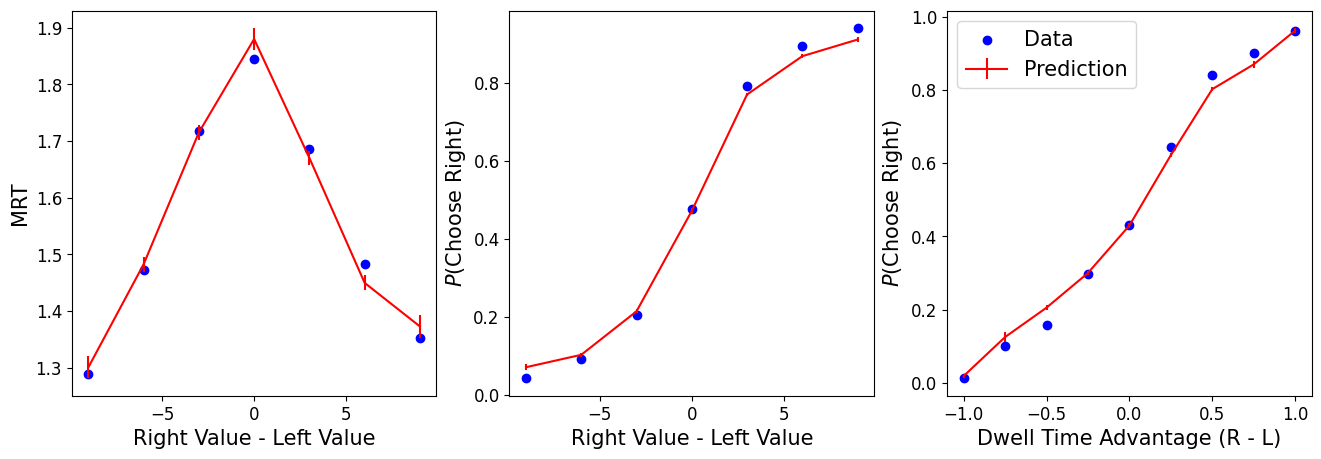

In [13]:
plt.figure(figsize=(16, 5))
plt.subplot(131)
se = pred_bhv.groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(pred_bhv.groupby(by='value_diff')['value_diff'].mean(),
             pred_bhv.groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red')
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel('MRT');

plt.subplot(132)
se = pred_bhv.groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv.groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['choice'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(133)
se = pred_bhv.groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(x=pred_bhv.groupby(by='gaze_diff')['gaze_diff'].mean(),
             y=pred_bhv.groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, label='Prediction', c='red');
plt.scatter(x=ts_df.groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df.groupby(by='Dwell Time Advantage (R - L)')['choice'].mean(), 
            c='blue', label='Data');
plt.xlabel('Dwell Time Advantage (R - L)');
plt.ylabel(r'$P$(Choose Right)');
plt.legend();

plt.savefig('_plots/tv2017_splitted_postpred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');

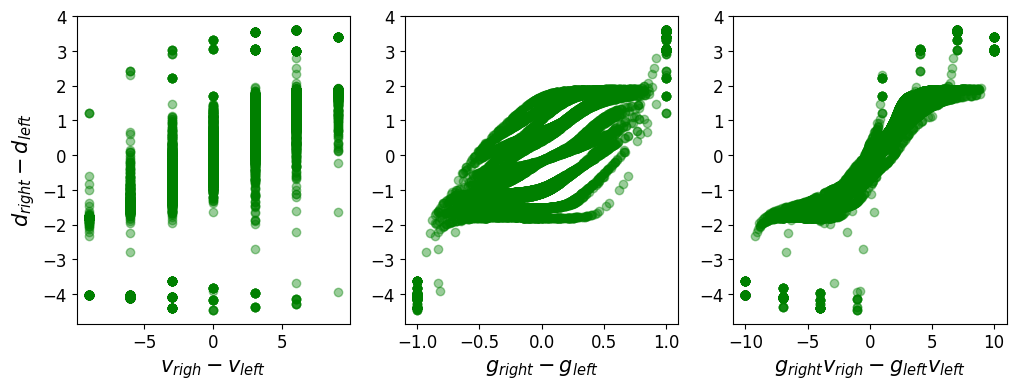

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 1] - X_test[:, 0], 
            pred_v[:, 1] - pred_v[:, 0], alpha=0.4, c='green');
plt.ylabel(r'$d_{right} - d_{left}$');
plt.xlabel(r'$v_{righ} - v_{left}$ ');

plt.subplot(132)
plt.scatter(X_test[:, 3] - X_test[:, 2], 
            pred_v[:, 1] - pred_v[:, 0], alpha=0.4, c='green');
plt.xlabel(r'$g_{right} - g_{left}$ ');

plt.subplot(133)
plt.scatter(X_test[:, 1]*X_test[:, 3] - X_test[:, 0]*X_test[:, 2], 
            pred_v[:, 1] - pred_v[:, 0], alpha=0.4, c='green');
plt.xlabel(r'$g_{right} v_{righ} - g_{left} v_{left}$ ');

plt.savefig('_plots/tv2017_splitted_prmspred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');